<a href="https://colab.research.google.com/github/hillsonghimire/EO-training-resources/blob/main/gee_py/05.VegetationDegradationStudies/CompoundIndices(VCI%2C_TCI%2C_VHI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
#  Title:  Calculation of Compound Indices VCI (Vegetation Condition Index), Temperature Condition index (TCI) and VHI (Vegetation Health Index)
#  Author: hillson ghimire
#  Date:   Jan 2024
# ==========================================

# Calculation of VCI (Vegetation Condition Index), Temperature Condition index (TCI) and VHI (Vegetation Health Index)

VCI , TCI and VHI are proxies for measuring environmental conditions such as drought, climate change, and overall vegetation health. They provide valuable information about how these conditions are changing over time, which can help inform decision-making related to land management and conservation efforts.

## Import necessary Libraries

In [ ]:
# !pip install geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import geemap
import ipywidgets as widgets

import ee
ee.Authenticate()

In [ ]:
ee.Initialize(project='gee-ait')

## Select Area of Interest

In [ ]:
# Map visualisation parameters
zoom = 5
width="30%"
height="500px"
center = [34,66]

# Select Area of Interest (AOI) using 'Draw a Rectangle' tool, the first drawn shape will become AOI
print("Select AOI using 'Draw a Rectangle' tool")
Map = geemap.Map(center = center, zoom = zoom, height=height, width=width)
feature = Map.draw_features
Map

In [ ]:
# extract bounding box polygon

features = []
for element in (Map.draw_control.data):
  new_dict = {key: value for key, value in element.items() if key == 'geometry'}  # grab only 'geometry' property from the dictionary.
  # print("new_dict:", new_dict)
  features.append(new_dict)

coords = features[0]['geometry']['coordinates']                                   # take only 'coordinates' value and ignore all other properties
aoi = ee.Geometry.Polygon(coords, None, False)                                    # convert to earth engine 'Polygon' type
display(aoi)

## Select ImageCollection from EE catalogue

In [ ]:
# define period of analysis
start_Date = "2001-01-01"
end_Date = "2023-12-31"
startDate = ee.Date(start_Date)
endDate = ee.Date(end_Date)

# get MODIS Terra Vegetation Indices image collection and select NDVI band
# MOD13Q1.061 Terra Vegetation Indices 16-Day Global 250m
# https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13Q1 (note the scaling factor in documentation for each bands)

# Selecting the NDVI Band only. The image originally has NDVI and EVI values.
NDVI = ee.ImageCollection("MODIS/061/MOD13Q1").select('NDVI')
display(NDVI)

In [ ]:
NDVI_aoi = NDVI.first().clip(aoi)


Map = geemap.Map(center = center, zoom = zoom, height=height, width=width)
NDVI_VisParams = {'min':0, 'max':8000, 'palette': [
    '#ffffff', '#ce7e45', '#df923d', '#f1b555', '#fcd163', '#99b718', '#74a901',
    '#66a000', '#529400', '#3e8601', '#207401', '#056201', '#004c00', '#023b01',
    '#012e01', '#011d01', '#011301'
  ]}
Map.addLayer(NDVI_aoi, NDVI_VisParams, name="NDVI")
Map

**Shouldn't the NDVI value be in range of -1 to 1?**
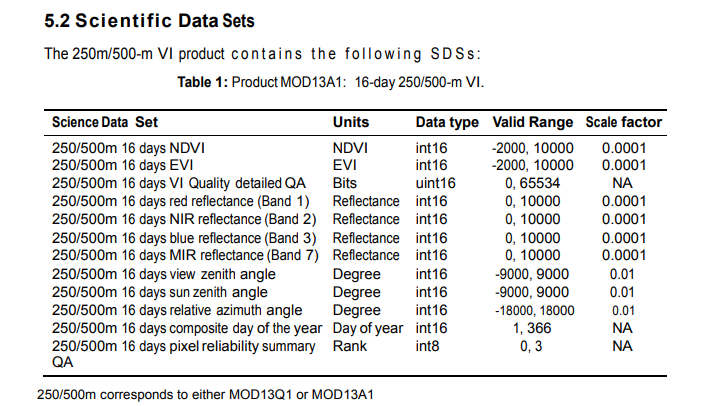



---



## A. Vegetation Condition Index (VCI) Calculation module
Formula : VCI = 100 * (NDVI - NDVI min) / (NDVI max - NDVI min) (Kogan, 1990)



In [ ]:
# function to compute VCI
def calcVCI(image):
  min = NDVI.reduce(ee.Reducer.min())
  max = NDVI.reduce(ee.Reducer.max())
  vci = image.subtract(min).divide(max.subtract(min)).multiply(100)
  return vci.rename('VCI').copyProperties(image, ['system:time_start', 'system:time_end'])

VCI = NDVI.filterDate(startDate, endDate).map(calcVCI)
display(VCI)

In [ ]:
# Map visualisation parameters
VisParams = {'min': 0, 'max': 100, 'palette': ['#d73027', '#fdae61', '#ffffbf', '#a6d96a', '#1a9850']}
vciLegend = {
  'Minimal': 'd73027',
  'Low': 'fdae61',
  'Average': 'ffffbf',
  'Moderate High': 'a6d96a',
  'High': '1a9850'
  }
Map = geemap.Map(center = center, zoom = zoom, height=height, width=width)
Map.addLayer(VCI.first().clip(aoi), VisParams, name="VCI")
Map.add_legend("VCI Value", legend_dict=vciLegend)
Map

## B. Temperature Condition Index (TCI) calculation module

Formula : *TCI* = 100 * (BTmax - BT) / (BTmax – BTmin) (Kogan, 1995);
where

*BT* = Brightness Temperature

*BTmax* and *BTmin* = year maximum and minimum, pixel specific thermal brightness temperature

In [ ]:
# get land surface temperature from MODIS Terra an select 8-Day Global dataset
# LST = ee.ImageCollection("MODIS/061/MOD11A2").select('LST_Day_1km')
# display(LST)

In [ ]:
# get land surface temperature from MODIS Terra an select 8-Day Global dataset
LST = ee.ImageCollection("MODIS/061/MOD11A2").select('LST_Day_1km')

# function to combine LST images to 16-Day using mean
# note that LST is 8-Day while NDVI is 16-Day
def convertLstDatesToModisDates(ndvimg):
  start = ndvimg.get('system:time_start')     # first observation time (day1)
  end = ndvimg.get('system:time_end')         # final observation time (day16)

  composite = LST \
    .filterDate(start, end) \
    .mean()                                   # combining images using mean (between day 1 and day 16)

  return composite \
    .set('system:time_start', start) \
    .set('date', ee.Date(start).format()) \
    .set('system:time_end', end) \
    .set('empty', composite.bandNames().size().eq(0))

filteredlst = NDVI.filterDate(startDate, endDate).map(convertLstDatesToModisDates)


display(LST.size())
display(filteredlst.size())

In [ ]:
# function to compute TCI
def calcTCI(image):
  min = LST.reduce(ee.Reducer.min())
  max = LST.reduce(ee.Reducer.max())
  tci = max.subtract(image).divide(max.subtract(min)).multiply(100)
  return tci.rename('TCI').copyProperties(image, ['system:time_start', 'system:time_end'])

TCI = filteredlst.filterDate(startDate, endDate).map(calcTCI)
display(TCI)

*VCI Values: The VCI is expressed in % and gives an idea where the observed value is situated between the extreme values (minimum and maximum). Lower and higher values indicate bad and good vegetation state conditions, respectively. VCI varies from 0 for extremely unfavorable conditions, to 100 for optimal.*

### C. Vegetation Health Index (VHI) calculation module

In [ ]:
# define filter and join parameters to combine VCI & TCI
filter = ee.Filter.equals(leftField= 'system:time_start', rightField= 'system:time_start')
join = ee.Join.saveFirst(matchKey = 'match')

# combine the two image collections
def combn(img):
    return img.addBands(img.get('match')).set('date', img.date().format('YYYY_MM_dd'))

both = ee.ImageCollection(join.apply(VCI, TCI, filter)).map(combn)

# compute VHI and add it as a band to the collection
def calcVHI(img):
  return img.addBands(
    img.expression('a1/2 + b1/2', {
      "a1": img.select('VCI'),
      "b1": img.select('TCI'),
    }).rename('VHI')
  )

VHI = both.map(calcVHI)

display(VHI)

##### Visualize VHI

In [ ]:
# Class color and label info.
vhiLegend = {
  'Extreme': 'd73027',
  'Severe': 'fdae61',
  'Moderate': 'ffffbf',
  'Mild': 'a6d96a',
  'No Drought': '1a9850'
  }

Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(VHI.select('VHI').first(), VisParams, name="VHI")
Map.add_legend("VHI Drought", legend_dict=vhiLegend)
Map

In [ ]:
display(VHI)

##### Filtering January and June Observation only

In [ ]:
# dataPicking = [*range(10, 529, 23)]    # June month of each year
dataPicking = sorted([*range(1, 529, 23)] + [*range(10, 529, 23)])   # January and June month of each year

print(dataPicking)
len(dataPicking)

In [ ]:
# Create list of images corresponding to May of each year
imageList = VHI.toList(VHI.size())

# my_indices = ee.List([9,32,55,78,101,124,147,170,193,216,239,262,285, 308])   # difference of 23 cycle
my_indices=ee.List(dataPicking)

# select images using their index
def getImages(list):
  img = ee.Image(imageList.get(list))
  return img

# create a image collection of the images
finalCollection = ee.ImageCollection.fromImages(my_indices.map(getImages))

# Every may imageCollection with VCI, TCI, VHI Bands
display(finalCollection)

In [ ]:
# Check the bands information in above feature collection
finalCollection.first().bandNames().getInfo()

##### Clip finalCollection to our AOI

In [ ]:
def clip(img):
  return img.clip(aoi)

clippedCol = finalCollection.map(clip)
Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(clippedCol.select('VHI').first(), VisParams, name="VHI")
Map

### See the image statistics

In [ ]:
# Function definition for image reducer
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)
    return ee.Feature(geometry, stat).set({'millis': img.date().millis(), })
  return reduce_region_function

# Create function
reduce_index = create_reduce_region_function(
     geometry=aoi,
     reducer=ee.Reducer.mean(), scale=1000, crs='EPSG:4326')

# Create FeatureCollection of image statistics with additional "geometry" and "millis" field
# pass input FeatureCollection "clippedCol"
stat_fc = ee.FeatureCollection(clippedCol.map(reduce_index))

# Display output
display(stat_fc)

In [ ]:
# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [ ]:
data_dict = fc_to_dict(stat_fc).getInfo()
data_df = pd.DataFrame(data_dict)
display(data_df.head(10))

In [ ]:
# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

data_df = add_date_info(data_df)
data_df = data_df.drop(columns=['millis', 'system:index'])
display(data_df.head(10))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_df["Timestamp"], data_df["VHI"])
# plt.ylim(35, 60)

# Calculate and add linear regression fitting line
x = np.arange(len(data_df))
coefficients = np.polyfit(x, data_df["VHI"], 1)
poly_fit = np.poly1d(coefficients)
plt.plot(data_df["Timestamp"], poly_fit(x), color='black', label='Linear Regression Fit'+str(poly_fit))

# Add labels and legend
plt.xlabel('Year')
plt.xticks(data_df["Timestamp"][::1],  rotation='vertical')

plt.ylabel('%-VCI')
plt.legend()
plt.show()

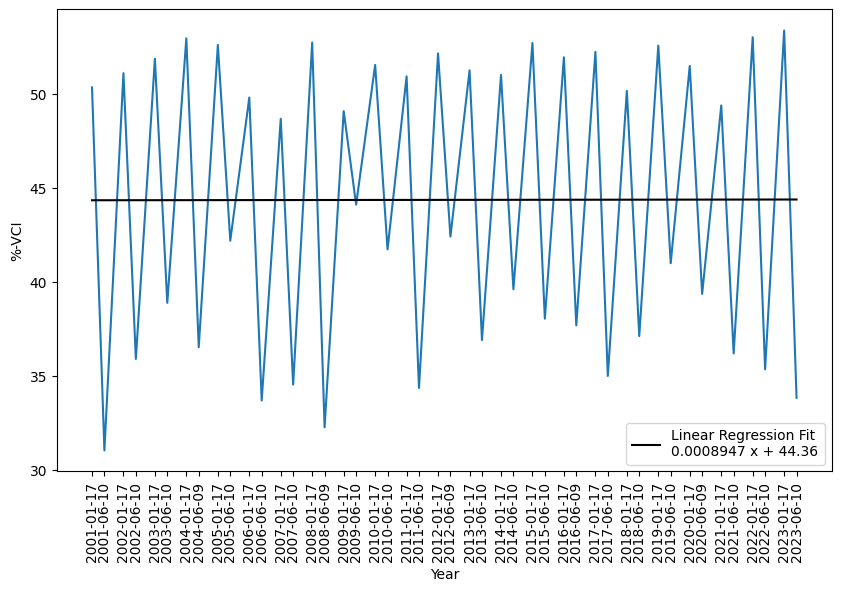

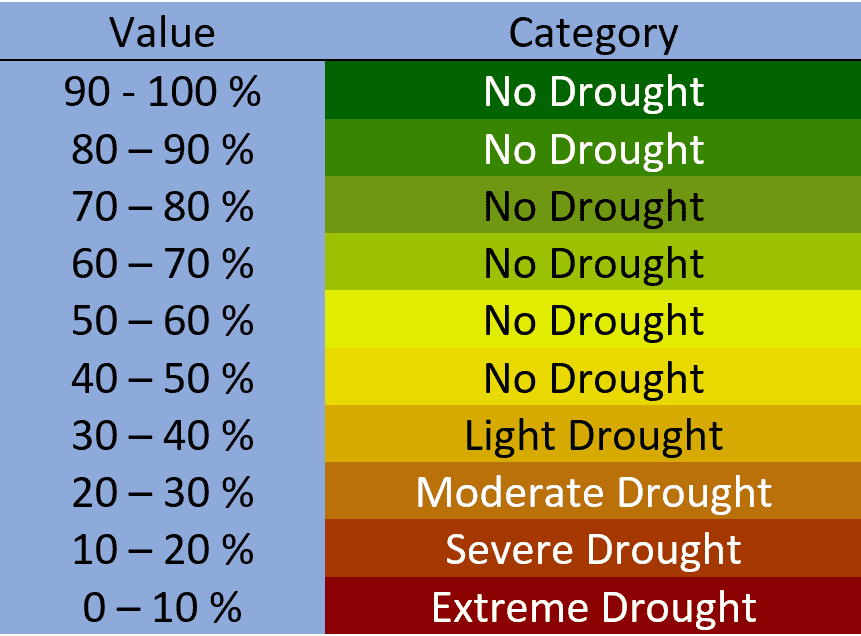

References:
1. https://un-spider.org/advisory-support/recommended-practices/recommended-practice-agriculture-drought-monitoring/step-by-step
2. https://un-spider.org/advisory-support/recommended-practices/recommended-practice-drought-monitoring/in-detail